# <font color ='green'> Cohort Analysis and Visualization</font>
Grouping customers into simple behavioral segments.<br>
This analysis can be used for two primary purposes: <br>
1. For one-time campaign retrospection
2. For ongoing user engagement benchmarking<br><br>
***Medium article with more info:***
https://medium.com/analytics-for-humans/what-is-cohort-analysis-and-how-should-i-use-it-3ac7c39c50dd

# <font color = 'teal'> Import Libraries </font>

In [2]:
# Basic data manipulation
import numpy as np
import math
import pandas as pd
pd.set_option('display.max_columns', 20)
import datetime as dt
import qgrid
import requests

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# <font color = 'teal'> Read and Inspect Data </font>

In [6]:
#GitHub data location
data = 'https://github.com/michael-william/Cohort-analysis/raw/master/Online%20Retail.xlsx'
source = pd.ExcelFile(data)

In [7]:
online = pd.read_excel(source, 'Online Retail')

In [8]:
qgrid.show_grid(online, show_toolbar=True)

# or
#online.head()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [6]:
online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
#Dropping nulls
online = online.dropna().reset_index(drop=True)

In [8]:
#Sorting to make it easier to spot check
online = online.sort_values('CustomerID').reset_index(drop=True)

### Assign daily acquisition cohort (CohortDay)##

In [9]:
# Define a function that will parse the date
def get_day(x): 
    return dt.datetime(x.year, x.month, x.day) 

# Create InvoiceDay column
online['InvoiceDay'] = online['InvoiceDate'].apply(get_day) 

# Group by CustomerID and select the InvoiceDay value
grouping = online.groupby('CustomerID')['InvoiceDay'] 

# Assign a minimum InvoiceDay value to the dataset
online['CohortDay'] = grouping.transform('min').astype('datetime64[ns]')

# View the top 5 rows
online.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,2011-01-18
1,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,2011-01-18,2011-01-18
2,562032,21578,WOODLAND DESIGN COTTON TOTE BAG,6,2011-08-02 08:48:00,2.25,12347.0,Iceland,2011-08-02,2010-12-07
3,542237,47559B,TEA TIME OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347.0,Iceland,2011-01-26,2010-12-07
4,542237,21154,RED RETROSPOT OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347.0,Iceland,2011-01-26,2010-12-07


### Calculate time offset in days - part 1##

In [10]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [11]:
# Get the integers for date parts from the `InvoiceDay` column
invoice_year, invoice_month, invoice_day = get_date_int(online, 'InvoiceDay')

# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, cohort_day = get_date_int(online, 'CohortDay')

### Calculate time offset in days - part 2 (ChortIndex)

In [12]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Calculate difference in days
days_diff = invoice_day - cohort_day

# Extract the difference in days from all previous values
online['CohortIndex'] = years_diff * 365 + months_diff * 30 + days_diff + 1
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortIndex
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,2011-01-18,1
1,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,2011-01-18,2011-01-18,1
2,562032,21578,WOODLAND DESIGN COTTON TOTE BAG,6,2011-08-02 08:48:00,2.25,12347.0,Iceland,2011-08-02,2010-12-07,241
3,542237,47559B,TEA TIME OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347.0,Iceland,2011-01-26,2010-12-07,55
4,542237,21154,RED RETROSPOT OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347.0,Iceland,2011-01-26,2010-12-07,55


In [13]:
# Converting CohortIndex to months from days
online['CohortIndex'] = np.ceil(np.divide(online.CohortIndex,30)).astype('int')

# <font color = 'teal'> Cohort Metrics </font>

### Calculate retention from scratch

In [14]:
#Adding CohortMonth from CohortDay in dt format
online['CohortMonth'] =  online.CohortDay + pd.offsets.MonthBegin(1)

In [15]:
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

In [16]:
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

In [17]:
# Count the number of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

# Create a pivot 
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention = (cohort_counts.divide(cohort_sizes, axis=0) * 100).round(2)
retention.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2011-01-01,100.0,38.29,34.49,38.50,36.29,39.03,37.03,35.44,34.92,38.29,40.61,50.74,19.73
2011-02-01,100.0,24.70,28.98,30.40,30.17,28.98,25.65,27.55,33.73,35.15,28.50,1.43,NaN
2011-03-01,100.0,23.42,23.95,29.47,20.79,26.84,25.53,27.89,28.95,25.00,0.79,NaN,NaN
2011-04-01,100.0,18.64,25.00,23.18,19.55,22.05,24.32,27.05,21.82,2.50,NaN,NaN,NaN
2011-05-01,100.0,27.42,17.73,22.41,18.39,23.75,24.75,22.74,2.34,NaN,NaN,NaN,NaN


### Calculate average price

In [18]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = online.groupby(['CohortMonth', 'CohortIndex']) 

# Calculate the average of the unit price column
cohort_data = grouping['UnitPrice'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')
average_price = average_price.round(2)
average_price.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2011-01-01,3.20,3.19,3.23,3.57,2.90,4.99,3.15,3.25,3.45,3.08,3.21,2.85,2.81
2011-02-01,3.50,3.38,7.34,3.12,3.33,2.88,2.77,2.72,5.63,3.00,2.77,2.36,NaN
2011-03-01,3.52,4.78,2.94,3.14,2.97,2.72,3.19,3.00,2.89,3.06,2.54,NaN,NaN
2011-04-01,3.49,3.86,3.32,3.53,3.08,2.79,2.77,2.79,2.66,3.15,NaN,NaN,NaN
2011-05-01,3.42,3.82,3.16,2.86,2.88,2.88,2.72,2.91,2.54,NaN,NaN,NaN,NaN


### Calculate average quantity

In [19]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = online.groupby(['CohortMonth', 'CohortIndex']) 

# Calculate the average of the unit price column
cohort_data = grouping['Quantity'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')
average_quantity = average_quantity.round(1)
average_quantity.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2011-01-01,11.3,14.5,14.1,15.0,14.6,13.3,14.4,17.5,14.8,17.2,16.9,13.0,13.1
2011-02-01,9.8,15.2,11.3,10.7,12.7,15.4,14.2,14.0,11.4,8.5,9.2,12.2,NaN
2011-03-01,10.8,13.9,16.1,11.8,10.4,13.2,13.0,11.2,10.0,13.8,18.8,NaN,NaN
2011-04-01,9.7,11.0,11.8,9.9,13.8,13.9,10.8,13.7,9.3,5.7,NaN,NaN,NaN
2011-05-01,9.8,8.7,11.8,11.3,11.1,8.6,9.3,9.5,5.6,NaN,NaN,NaN,NaN


# <font color = 'teal'>Cohot Analysis Visualization</font>

No handles with labels found to put in legend.


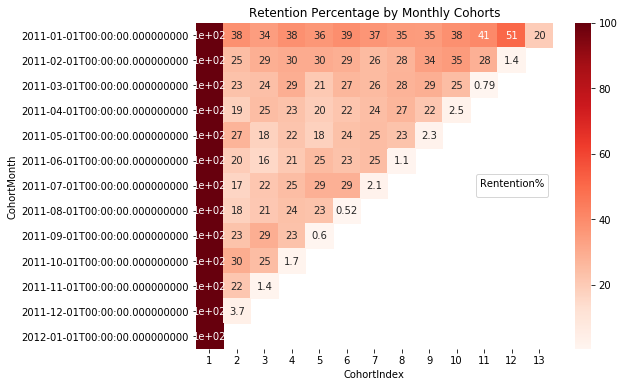

In [20]:
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8, 6))

# Add a title
plt.title('Retention Percentage by Monthly Cohorts')

# Create the heatmap
ax = sns.heatmap(data = retention, annot=True, cmap='Reds')
plt.yticks(rotation = 0)
ax.legend(loc = 'right' , title = "Rentention%")
plt.show()

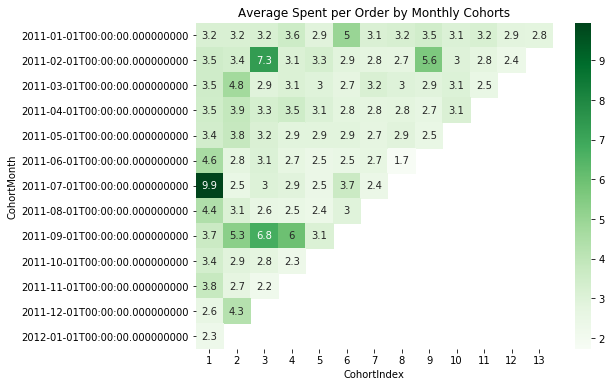

In [21]:
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8, 6))

# Add a title
plt.title('Average Spent per Order by Monthly Cohorts')

# Create the heatmap
ax = sns.heatmap(data = average_price, annot=True, cmap='Greens')
plt.yticks(rotation = 0)
plt.show()

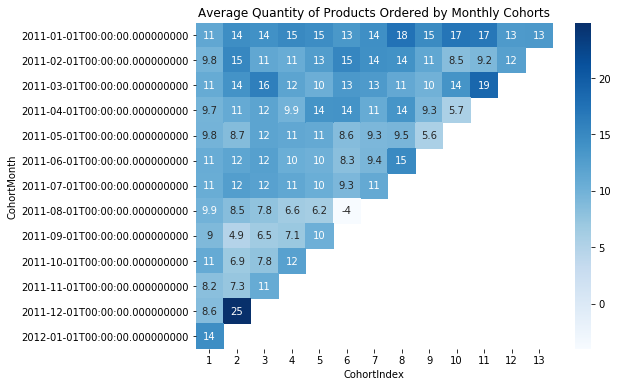

In [22]:
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8, 6))

# Add a title
plt.title('Average Quantity of Products Ordered by Monthly Cohorts')

# Create the heatmap
ax = sns.heatmap(data = average_quantity, annot=True, cmap='Blues')
plt.yticks(rotation = 0)
plt.show()

# <font color = 'teal'>RFMT Sementation Recency Frequency Monetary</font>
https://en.wikipedia.org/wiki/RFM_(market_research)
- Recency - days since last customer transaction
- Frequecy - number of transaction in the last 12 months
- Monetary Value - total spend in last 12 months
- Tenure - days since first transaction

**Can group by:**
  - Percentiles (chosen for this project)
  > 1. Sort customers based on percentile
  > 2. Break customers into a pre-defined number of groups of equal size
  > 3. Assign a label to each group
  - Pareto 80/20 cut
  - Custom, based on business knowledge


### Adjusting data to only last 12 months of invoices

In [23]:
print('Min invoice date:{}; Max invoice data:{}'.format(min(online.InvoiceDate), max(online.InvoiceDate)))

Min invoice date:2010-12-01 08:26:00; Max invoice data:2011-12-09 12:50:00


In [24]:
#Data is already adjusted to last 12 months 
#Data is old, so creating hypothetical snap_shot data as if we're doing analysis recently
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days=1)

### Calculate RFMT Metrics

In [25]:
# Aggregate data on a customer level

In [26]:
rfmt = online.groupby('CustomerID')
rfmt = rfmt.agg(Recency = ('InvoiceDate','max'),
            Frequency = ('InvoiceNo','size'),
           Monetary_Value = ('UnitPrice', 'sum'),
             Tenure = ('InvoiceDate','min'))

In [27]:
recency_days = []
for x in rfmt.Recency:
    diff = snapshot_date-x
    diff = diff/np.timedelta64(1,"D")
    diff = np.ceil(diff).astype('int')
    recency_days.append(diff)

In [28]:
rfmt['Recency'] = recency_days

In [29]:
tenure_days = []
for x in rfmt.Tenure:
    diff = snapshot_date-x
    diff = diff/np.timedelta64(1,"D")
    diff = np.ceil(diff).astype('int')
    tenure_days.append(diff)

In [30]:
rfmt['Tenure'] = tenure_days

In [31]:
rfmt.index = rfmt.index.astype('int')
rfmt.index.name='CustomerID'
rfmt

,Recency,Frequency,Monetary_Value,Tenure
CustomerID,,,,
12346,327,2,2.08,327
12347,3,182,481.21,368
12348,76,31,178.71,359
12349,20,73,605.10,20
12350,311,17,65.30,311
...,...,...,...,...
18280,279,10,47.65,279
18281,182,7,39.36,182
18282,9,13,62.68,127


In [32]:
# Dropping rows where monetary value = 0 for later pre-processing steps
rfmt = rfmt[rfmt.Monetary_Value != 0]

### Building RFMT segments

In [33]:
import warnings
warnings.filterwarnings('ignore')

# Generator of labels for recency where 4 is best and 1 is worst
r_labels = range(4,0,-1)

# Recency quartiles
r_quartiles = pd.qcut(rfmt.Recency,4,labels=r_labels)

# Append recency quartiles to dataframe
rfmt['R'] = r_quartiles

In [34]:
# Generator of labels for frequency and monetary where 1 is best and 4 is worst
f_labels = range(1,5)
m_labels = range(1,5)
t_labels = range(1,5)

# frequency and monetary quartiles
f_quartiles = pd.qcut(rfmt.Frequency,4,labels=f_labels)
m_quartiles = pd.qcut(rfmt.Monetary_Value,4,labels=m_labels)
t_quartiles = pd.qcut(rfmt.Tenure,4,labels=t_labels)

# Append recency quartiles to dataframe
rfmt['F'] = f_quartiles
rfmt['M'] = m_quartiles
rfmt['T'] = t_quartiles
rfmt.head()

,Recency,Frequency,Monetary_Value,Tenure,R,F,M,T
CustomerID,,,,,,,,
12346,327,2,2.08,327,1,1,1,3
12347,3,182,481.21,368,4,4,4,4
12348,76,31,178.71,359,2,2,3,4
12349,20,73,605.10,20,3,3,4,1
12350,311,17,65.30,311,1,1,2,3


In [35]:
# Creating RFMT segement
def join_rfmt(x):
    return str(x.R) + str(x.F) + str(x.M) + str(x['T'])

rfmt['Segment'] = rfmt.apply(join_rfmt,axis=1)
rfmt


,Recency,Frequency,Monetary_Value,Tenure,R,F,M,T,Segment
CustomerID,,,,,,,,,
12346,327,2,2.08,327,1,1,1,3,1113
12347,3,182,481.21,368,4,4,4,4,4444
12348,76,31,178.71,359,2,2,3,4,2234
12349,20,73,605.10,20,3,3,4,1,3341
12350,311,17,65.30,311,1,1,2,3,1123
...,...,...,...,...,...,...,...,...,...
18280,279,10,47.65,279,1,1,1,3,1113
18281,182,7,39.36,182,1,1,1,2,1112
18282,9,13,62.68,127,4,1,2,2,4122


In [36]:
rfmt['Score'] = rfmt[['R','F','M','T']].sum(axis=1).astype('int')
rfmt

,Recency,Frequency,Monetary_Value,Tenure,R,F,M,T,Segment,Score
CustomerID,,,,,,,,,,
12346,327,2,2.08,327,1,1,1,3,1113,6
12347,3,182,481.21,368,4,4,4,4,4444,16
12348,76,31,178.71,359,2,2,3,4,2234,11
12349,20,73,605.10,20,3,3,4,1,3341,11
12350,311,17,65.30,311,1,1,2,3,1123,7
...,...,...,...,...,...,...,...,...,...,...
18280,279,10,47.65,279,1,1,1,3,1113,6
18281,182,7,39.36,182,1,1,1,2,1112,5
18282,9,13,62.68,127,4,1,2,2,4122,9


### Analyzinf RFMT Segments

In [37]:
# Calculate size of segments
rfmt.groupby('Segment').size().sort_values(ascending=False)[:10]

Segment
4444    285
1112    164
1113    154
2111    151
3111    118
3444    111
4443    110
1114     96
3443     93
2221     92
dtype: int64

In [38]:
# Calculate size of Scores
rfmt.groupby('Score').size().sort_values(ascending=False)[:10]

Score
7     501
6     445
8     441
9     429
11    389
10    384
5     315
12    314
13    309
14    296
dtype: int64

In [39]:
# Summary metrics for RFMT Score
rfmt.groupby('Score').agg(Recency_avg = ('Recency','mean'),
                         Frequency_avg = ('Frequency','mean'), 
                         Monetary_avg =('Monetary_Value','mean'),
                         Tenure =('Tenure','mean'))

,Recency_avg,Frequency_avg,Monetary_avg,Tenure
Score,,,,
5,141.473016,8.279365,23.121810,143.834921
6,158.056180,10.784270,30.773171,170.932584
7,156.782435,17.451098,55.069202,186.524950
8,132.163265,25.514739,196.333107,185.451247
9,112.279720,36.557110,119.202494,194.890443
10,88.640625,51.656250,168.607531,217.630208
11,71.439589,68.940874,218.627843,219.748072
12,49.445860,94.550955,295.457898,249.974522
13,46.809061,152.456311,679.041133,266.695793


In [40]:
# Review distiburion of RFMT Score
rfmt.Score.describe()

count    4371.000000
mean        9.996340
std         3.303626
min         5.000000
25%         7.000000
50%        10.000000
75%        13.000000
max        16.000000
Name: Score, dtype: float64

In [41]:
# function for grouping into named segemnts by RFM Score
def segment_me(df):
    if df['Score'] >= 13:
        return 'Top'
    elif df['Score'] >=9 and (df['Score'] < 13):
        return 'Middle'
    else:
        return 'Bottom'

In [42]:
rfmt['General_Segment'] = rfmt.apply(segment_me, axis=1)
rfmt.head()

,Recency,Frequency,Monetary_Value,Tenure,R,F,M,T,Segment,Score,General_Segment
CustomerID,,,,,,,,,,,
12346,327,2,2.08,327,1,1,1,3,1113,6,Bottom
12347,3,182,481.21,368,4,4,4,4,4444,16,Top
12348,76,31,178.71,359,2,2,3,4,2234,11,Middle
12349,20,73,605.10,20,3,3,4,1,3341,11,Middle
12350,311,17,65.30,311,1,1,2,3,1123,7,Bottom


In [43]:
segments = rfmt.groupby('General_Segment').agg(Size = ('General_Segment','count'),
                                   Recency_avg = ('Recency','mean'), 
                                   Frequency_avg = ('Frequency','mean'), 
                                   Monetary_avg = ('Monetary_Value', 'mean'),
                                   Tenure_avg = ('Tenure','mean')).round(1).reindex(['Top', 'Middle', 'Bottom'])
segments

,Size,Recency_avg,Frequency_avg,Monetary_avg,Tenure_avg
General_Segment,,,,,
Top,1153,25.6,249.3,849.1,315.4
Middle,1516,82.8,60.7,193.7,218.4
Bottom,1702,147.9,16.1,79.4,174.3


In [44]:
segments['Share_Percent'] = (segments.Size/np.sum(segments.Size)*100).round(2)

In [45]:
segments = segments[['Size', 'Share_Percent', 'Recency_avg', 'Frequency_avg', 'Monetary_avg' ]]
segments

,Size,Share_Percent,Recency_avg,Frequency_avg,Monetary_avg
General_Segment,,,,,
Top,1153,26.38,25.6,249.3,849.1
Middle,1516,34.68,82.8,60.7,193.7
Bottom,1702,38.94,147.9,16.1,79.4


# <font color='teal'> Data Pre-Processing for k-means Clustering for Unsupervised Learning</font>

### Assumptions about data for k-means##
<br>
 1. Symetric distribution of variables (not skewed)<br>
 2. All variables have same average values to get equal weight in k-means calculation<br>
 3. All variables have the same variance <br> 

### 1. Managing skewed variables

In [46]:
#Creating rfmt_data for preprocessing
rfmt_data = rfmt[['Recency', 'Frequency','Monetary_Value', 'Tenure']]

#Unskew the data
rfmt_log = np.log(rfmt_data)

#Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(rfmt_log)

#Scale and center the data
rfmt_normalized = scaler.transform(rfmt_log)

#Create a pandas DataFrame
rfmt_normalized = pd.DataFrame(data=rfmt_normalized, index=rfmt_data.index, columns=rfmt_data.columns)

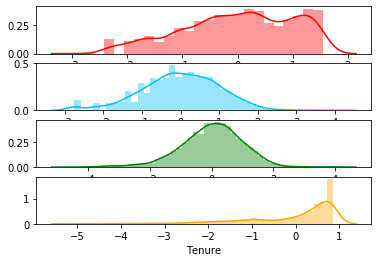

In [47]:
_=plt.subplot(4,1,1); sns.distplot(rfmt_normalized['Recency'], color='red')
_=plt.subplot(4,1,2); sns.distplot(rfmt_normalized['Frequency'], color='deepskyblue')
_=plt.subplot(4,1,3); sns.distplot(rfmt_normalized['Monetary_Value'], color='green')
_=plt.subplot(4,1,4); sns.distplot(rfmt_normalized['Tenure'], color='orange')
plt.show()

In [50]:
# To avoid manual transformation, use Stadard Scaller

# Combining centering and scaling automatically
scaler = StandardScaler()
scaler.fit(rfmt_log)

# Store seprate array for clustering
rfmt_normalized = scaler.transform(rfmt_log)

In [51]:
# Converting to dataframe 
rfmt_normalized= pd.DataFrame(rfmt_normalized,index = rfmt_log.index, columns=rfmt_log.columns)
rfmt_normalized.describe().round(2)

,Recency,Frequency,Monetary_Value,Tenure
count,4371.00,4371.00,4371.00,4371.00
mean,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-2.78,-2.75,-4.65,-5.07
25%,-0.66,-0.64,-0.58,-0.46
50%,0.10,0.04,0.05,0.42
75%,0.86,0.70,0.65,0.73
max,1.56,3.96,4.13,0.86


### Choose a number of clusters with k-means
***Methods for defining number of clusters***<br>
- Visual methods: elbow criterion (plotting # of clusters against sum-of-squared errors)<br>
- Mathmatical methods: silouette coeffcient<br>
- Experimentation and iterperation

In [52]:
### Manual cluster selection ### 
#Initialize kmeans
kmeans = KMeans(n_clusters=3, random_state=1)

# Compute k-means clustering on preprocessed data
kmeans.fit(rfmt_normalized)

# Extract the cluster labels
cluster_labels = kmeans.labels_
rfmt_k3 = rfmt.assign(Cluster = cluster_labels)

# Analyze result
rfmt_k3.groupby(['Cluster']).agg(Size = ('General_Segment','count'),
                    Recency = ('Recency','mean'), 
                              Frequency = ('Frequency','mean'), 
                              Monetary_Value = ('Monetary_Value','mean'),
                                     Tenure=('Tenure','mean')).round(2)

,Size,Recency,Frequency,Monetary_Value,Tenure
Cluster,,,,,
0,1799,34.65,188.06,659.11,285.73
1,1657,187.97,23.49,84.40,258.91
2,915,36.03,32.33,89.86,52.90


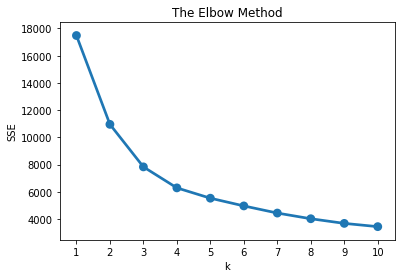

In [53]:
### Elbow criterion ### 

#Fit KMeans and calculate SSE for each k
sse = {}

#Initialize kmeans with k
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfmt_normalized)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# Plot SSE for each k
plt.title("The Elbow Method")
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### Profile and interpret segments

**Aproaches to build customer personas**<br>
- Summary statistics for each cluster e.g. average RFM values
- Snake plots (from market reserach)
- Calculate relative importance of cluster attributes compared to population

In [54]:
# Create a cluster label column in the original df with kmeans solution
# KMeans elbow shows '3'or'4' as the best number of clusters
kmeans4 = KMeans(n_clusters=4, random_state=1)

# Compute k-means clustering on preprocessed data
kmeans4.fit(rfmt_normalized)

# Extract the cluster labels
cluster_labels = kmeans4.labels_
rfmt_k4 = rfmt.assign(Cluster = cluster_labels)

In [55]:
# Create a cluster label column in the original df with alternative solution
kmeans3 = KMeans(n_clusters=3, random_state=1)

# Compute k-means clustering on preprocessed data
kmeans3.fit(rfmt_normalized)

# Extract the cluster labels
cluster_labels = kmeans3.labels_
rfmt_k3 = rfmt.assign(Cluster = cluster_labels)

In [56]:
# Calculate average RFM values and size k=4 
rfmt_k4.groupby(['Cluster']).agg(Size = ('General_Segment','count'),
                    Recency = ('Recency','mean'), 
                              Frequency = ('Frequency','mean'), 
                              Monetary_Value = ('Monetary_Value','mean'),
                                 Tenure=('Tenure','mean')).round(2)

,Size,Recency,Frequency,Monetary_Value,Tenure
Cluster,,,,,
0,851,33.15,35.10,99.74,49.51
1,1498,137.03,51.35,203.21,264.39
2,760,197.80,8.53,26.67,237.46
3,1262,18.19,232.60,791.02,295.40


In [57]:
# Calculate average RFM values and size for k=3
rfmt_k3.groupby(['Cluster']).agg(Size = ('General_Segment','count'),
                    Recency = ('Recency','mean'), 
                              Frequency = ('Frequency','mean'), 
                              Monetary_Value = ('Monetary_Value','mean'),
                                 Tenure=('Tenure','mean')).round(2)

,Size,Recency,Frequency,Monetary_Value,Tenure
Cluster,,,,,
0,1799,34.65,188.06,659.11,285.73
1,1657,187.97,23.49,84.40,258.91
2,915,36.03,32.33,89.86,52.90


### Snake plots to understand segements
- Market research technique to compare different segments
- Visual representation of each segment's attributes
- Need to first normalize (already done in steps above)

In [58]:
# Choosing only relevant columns where n_clusters = 4
rfmt_snake4 = rfmt_k4[['Recency', 'Frequency', 'Monetary_Value','Tenure','Cluster']]

In [59]:
# Melting data into a long format so RFM values and metric names are stored in 1 column each
rfmt_melt4 = pd.melt(rfmt_snake4.reset_index(),
                  id_vars=['CustomerID','Cluster'],
                  value_vars=['Recency', 'Frequency','Monetary_Value','Tenure'],
                  var_name='Attribute',
                  value_name='Value')
rfmt_melt4.head()

,CustomerID,Cluster,Attribute,Value
0,12346,2,Recency,327.0
1,12347,3,Recency,3.0
2,12348,1,Recency,76.0
3,12349,0,Recency,20.0
4,12350,1,Recency,311.0


In [60]:
# Choosing only relevant columns where n_clusters = 3
rfmt_snake3 = rfmt_k3[['Recency', 'Frequency', 'Monetary_Value','Tenure','Cluster']]


In [61]:
# Melting data into a long format so RFM values and metric names are stored in 1 column each
rfmt_melt3 = pd.melt(rfmt_snake3.reset_index(),
                  id_vars=['CustomerID','Cluster'],
                  value_vars=['Recency', 'Frequency','Monetary_Value','Tenure'],
                  var_name='Attribute',
                  value_name='Value')
rfmt_melt3.head()

,CustomerID,Cluster,Attribute,Value
0,12346,1,Recency,327.0
1,12347,0,Recency,3.0
2,12348,1,Recency,76.0
3,12349,2,Recency,20.0
4,12350,1,Recency,311.0


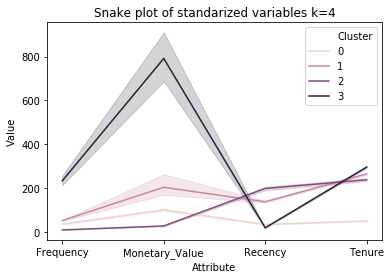

In [62]:
# Visulaize snake plot k=4
plt.title('Snake plot of standarized variables k=4')
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=rfmt_melt4)
plt.show()

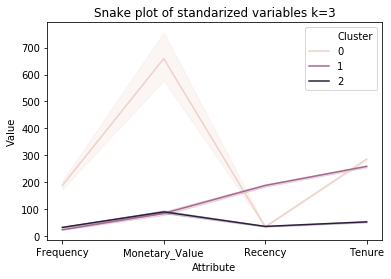

In [63]:
# Visulaize snake plot k=4
plt.title('Snake plot of standarized variables k=3')
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=rfmt_melt3)
plt.show()

In [64]:
#Renaming lables based on visualization
k4_new_labels = {3:'Gold',1:'Silver',2:'Bronze',0:'New'}
rfmt_k4 = rfmt_k4.replace({'Cluster':k4_new_labels})
rfmt_melt4 = rfmt_melt4.replace({'Cluster':k4_new_labels})
rfmt_snake4 = rfmt_snake4.replace({'Cluster':k4_new_labels})

In [65]:
#Renaming lables based on visualization
k3_new_labels = {1:'Sleepers',2:'New',0:'Loyal'}
rfmt_k3 = rfmt_k3.replace({'Cluster':k3_new_labels})
rfmt_melt3 = rfmt_melt3.replace({'Cluster':k3_new_labels})
rfmt_snake3 = rfmt_snake3.replace({'Cluster':k3_new_labels})

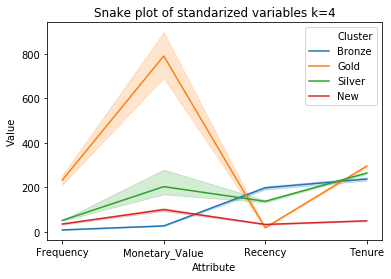

In [82]:
# Visulaize snake plot k=4
plt.title('Snake plot of standarized variables k=4')
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=rfmt_melt4)
plt.show()

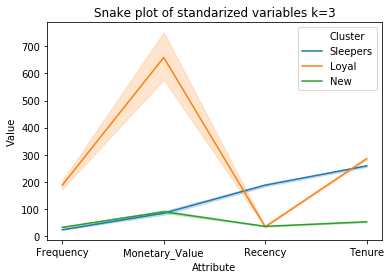

In [67]:
# Visulaize snake plot k=3
plt.title('Snake plot of standarized variables k=3')
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=rfmt_melt3)
plt.show()

### Relative importance of segment attributes
- Useful technique to identify relative importance of each segment's attribute
- Calculate average values of each cluster
- Calculate average values of population

In [68]:
cluster_avg4 = rfmt_snake4.groupby(['Cluster']).mean()
population_avg4 = rfmt_snake4.mean()
relative_imp4 = cluster_avg4/population_avg4 - 1

In [69]:
relative_imp4.round(2)

,Recency,Frequency,Monetary_Value,Tenure
Cluster,,,,
Bronze,1.13,-0.91,-0.92,0.05
Gold,-0.80,1.50,1.46,0.30
New,-0.64,-0.62,-0.69,-0.78
Silver,0.47,-0.45,-0.37,0.17


In [70]:
cluster_avg3 = rfmt_snake3.groupby(['Cluster']).mean()
population_avg3 = rfmt_snake3.mean()
relative_imp3 = cluster_avg3/population_avg3 - 1

In [71]:
relative_imp3.round(2)

,Recency,Frequency,Monetary_Value,Tenure
Cluster,,,,
Loyal,-0.63,1.02,1.05,0.26
New,-0.61,-0.65,-0.72,-0.77
Sleepers,1.02,-0.75,-0.74,0.14


### Analyze relative importance
- The further a ratio is from 0, the more important that attribute is for segment relative to population

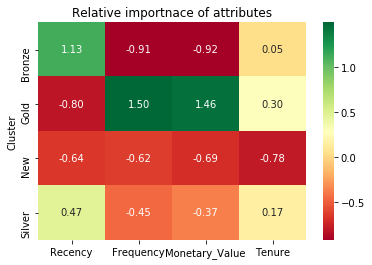

In [72]:
plt.figure(figsize=(6,4))
plt.title('Relative importnace of attributes')
sns.heatmap(data=relative_imp4, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

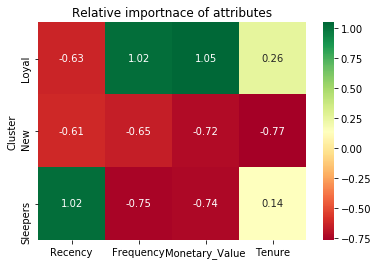

In [73]:
plt.figure(figsize=(6,4))
plt.title('Relative importnace of attributes')
sns.heatmap(data=relative_imp3, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()